# Advanced ML - EX2

In this assignment, you will implement Ensemble Learning methods - Gradient Boosting Regression Trees (GBRT) and AdaBoost. You will demonstrate the models and design experiments to test their performance.
You will submit a single ipython notebook (.ipynb) file that includes all the code and outputs, as well as a brief report that explains your approach and findings. You are encouraged to use methods and techniques covered in class but are also welcome to use any other relevant method you find suitable for the task.

## Imports

In [1]:
import sklearn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

## Part 0: Generate datasets
1) Generate at least two datasets with one binary label.
2) Split the data to train and test sets
3) Visualize the data (You can use dimensionality reduction if needed)


We will generate two datasets:

Dataset 1: It will contain 1000 samples with 10 features. </br>
Dataset 2: It will contain 1000 samples with 5 features.

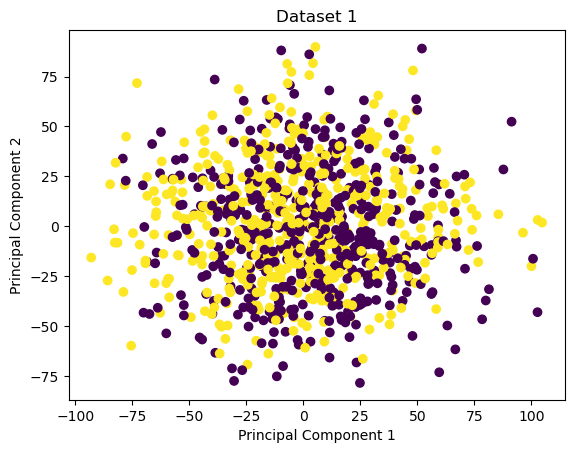

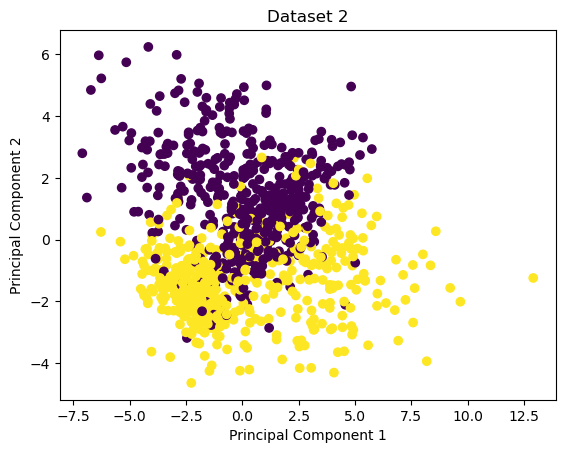

In [31]:
# Dataset 1: 1000 samples, 10 features
X1, y1 = make_classification(n_samples=1000, n_features=100, n_informative=95, random_state=1) # only 5 are informative, the rest are a linear combination of the informative ones
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=1)

# Dataset 2: 1000 samples, 5 features
X2, y2 = make_classification(n_samples=1000, n_features=5, n_informative=3, random_state=2) # only 3 are informative, the rest are a linear combination of the informative ones

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=2)

# Visualize Dataset 1
pca = PCA(n_components=2)
X1_transformed = pca.fit_transform(X1)

plt.scatter(X1_transformed[:, 0], X1_transformed[:, 1], c=y1)
plt.title('Dataset 1')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Visualize Dataset 2
X2_transformed = pca.fit_transform(X2)

plt.scatter(X2_transformed[:, 0], X2_transformed[:, 1], c=y2)
plt.title('Dataset 2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


We generally expect it to be somewhat segmented because there is a relation between the features and the target var.
Seems that dataset2 gets segmented easier, that is probably because it has less features, and it has less not informative features. 

## Part 1: Gradient Boosting Regression Trees (GBRT)
</br>
4) Implement GBRT 
</br>
a) Loss function
</br>
b) Residuals calculation
</br>
c) Weak regression tree
</br>
d) Boosting step

### Model Evaluation

First, we'll implement a generic model evaluation function

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
def evaluate_model(model, X_train, y_train, X_test, y_test, n_estimators=100, learning_rate=0.1, tree_depth=3, adaboost_flag=False):
    if adaboost_flag:
        model = model(n_estimators=n_estimators)
    else:
        model = model(n_estimators=n_estimators, learning_rate=learning_rate, tree_depth=tree_depth)
    model.fit(X_train, y_train.astype(int))

    # Predict probabilities for training set
    y_train_pred_proba = model.predict_proba(X_train)
    # Convert probabilities to binary predictions (0 or 1) for training set
    y_train_pred = np.round(y_train_pred_proba)

    # Predict probabilities for test set
    y_test_pred_proba = model.predict_proba(X_test)
    # Convert probabilities to binary predictions (0 or 1) for test set
    y_test_pred = np.round(y_test_pred_proba)

    # Evaluate performance on training set
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)

    # Evaluate performance on test set
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)

    return accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test


5) Demonstrate your GBRT model on the datasets you generated
6) Design and perform experiments to test the performance of your model. Present and discuss
the results of the experiments.


In [5]:
class GBRT:
    def __init__(self, n_estimators, learning_rate, tree_depth):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.tree_depth = tree_depth
        self.estimators = []
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def log_loss(self, y_true, y_pred):
        return -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def fit(self, X, y):
        # Initialize the predicted probabilities
        y_pred = np.zeros(len(X))
        
        for _ in range(self.n_estimators):
            # Calculate the negative gradient (residuals)
            residuals = y - self.sigmoid(y_pred)
            
            # Train a weak regression tree on the residuals
            tree = DecisionTreeRegressor(criterion='squared_error',  max_depth=self.tree_depth)
            tree.fit(X, residuals)
            
            # Update the predicted probabilities
            y_pred += self.learning_rate * tree.predict(X)
            
            # Store the weak regression tree
            self.estimators.append(tree)
            
    def predict_proba(self, X):
        y_pred = np.zeros(len(X))
        for tree in self.estimators:
            y_pred += self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)


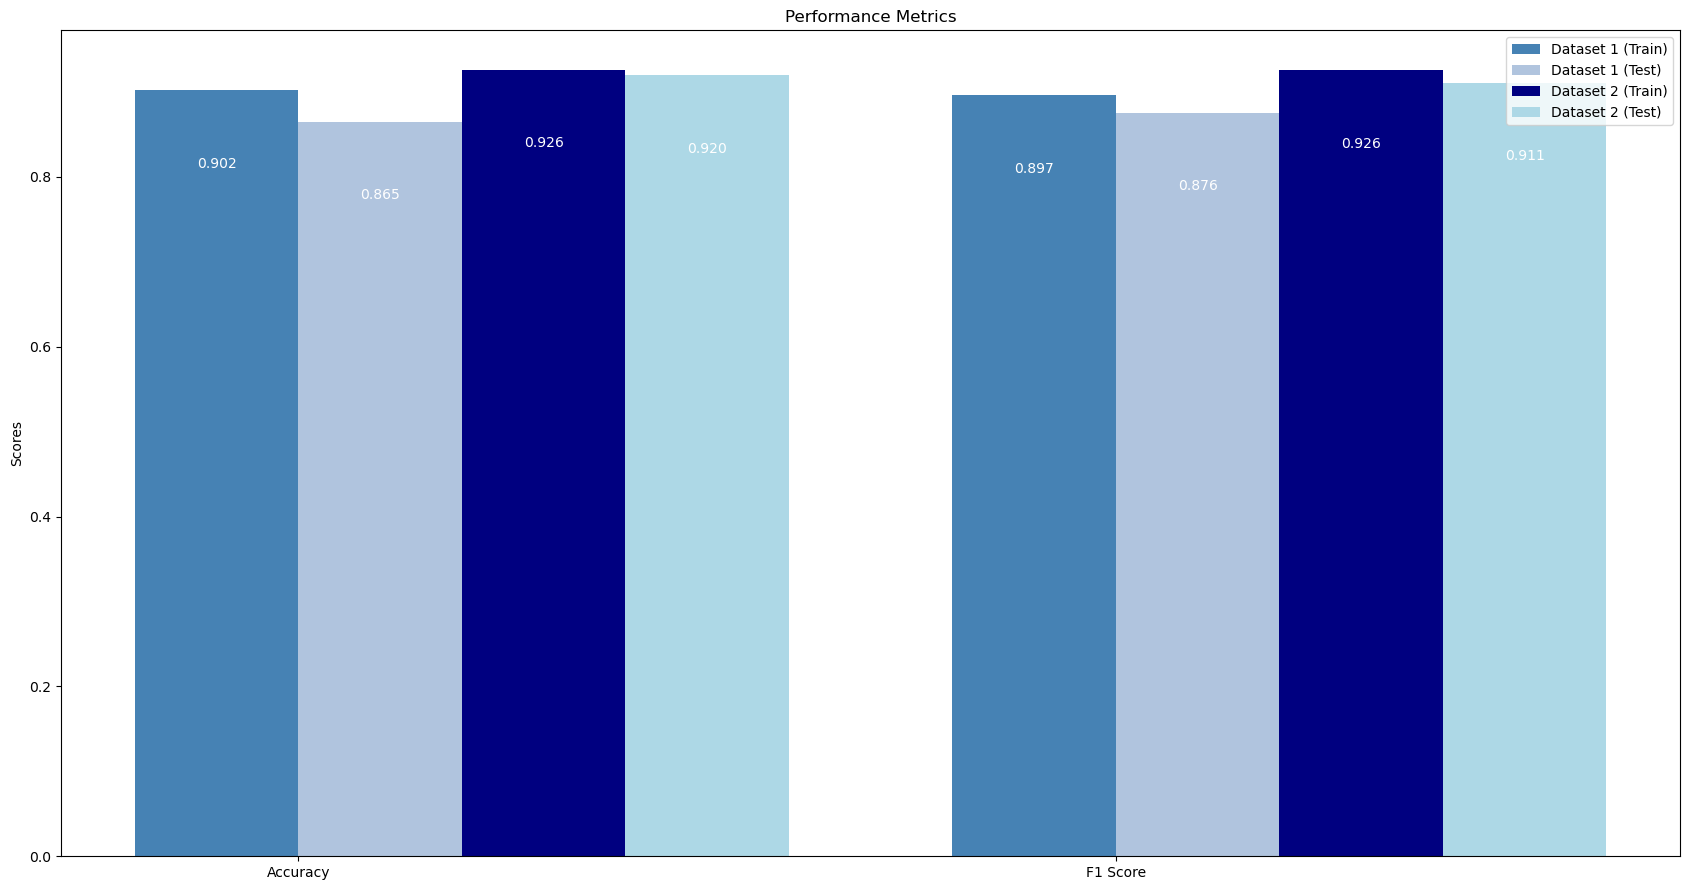

In [6]:
# Evaluate GBRT on Dataset 1
accuracy_train1, precision_train1, recall_train1, f1_train1, accuracy_test1, precision_test1, recall_test1, f1_test1 = evaluate_model(GBRT, X1_train, y1_train.astype(int), X1_test, y1_test.astype(int))

# Evaluate GBRT on Dataset 2
accuracy_train2, precision_train2, recall_train2, f1_train2, accuracy_test2, precision_test2, recall_test2, f1_test2 = evaluate_model(GBRT, X2_train, y2_train.astype(int), X2_test, y2_test.astype(int))

# Create a bar plot
labels = ['Accuracy', 'F1 Score']
dataset1_train_scores = [accuracy_train1, f1_train1]
dataset1_test_scores = [accuracy_test1, f1_test1]
dataset2_train_scores = [accuracy_train2, f1_train2]
dataset2_test_scores = [accuracy_test2, f1_test2]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(17, 9))
rects1 = ax.bar(x - width/2, dataset1_train_scores, width, label='Dataset 1 (Train)', color='steelblue')
rects2 = ax.bar(x + width/2, dataset1_test_scores, width, label='Dataset 1 (Test)', color='lightsteelblue')
rects3 = ax.bar(x + 3*width/2, dataset2_train_scores, width, label='Dataset 2 (Train)', color='navy')
rects4 = ax.bar(x + 5*width/2, dataset2_test_scores, width, label='Dataset 2 (Test)', color='lightblue')

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='best')

# Add text labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.3f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height-0.1),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.tight_layout()
plt.show()




it seems that the model performs better on dataset2, which is interesting, becuase it has less informative features (3, dataset1 has 5). This could be because that dataset1 has a total of 10 features, and 5 of them are informative, which could potentially cause overfitting. <br>Note, this does not mean that dataset2 will always have better performance; perhaps, with regularizationn methods, such as using smaller max depth for the trees, we could make it work better for dataset1.

### Experiments

#### DS1 

##### N Estimators
Now let's see how n_estimators (number of trees used) effects the model

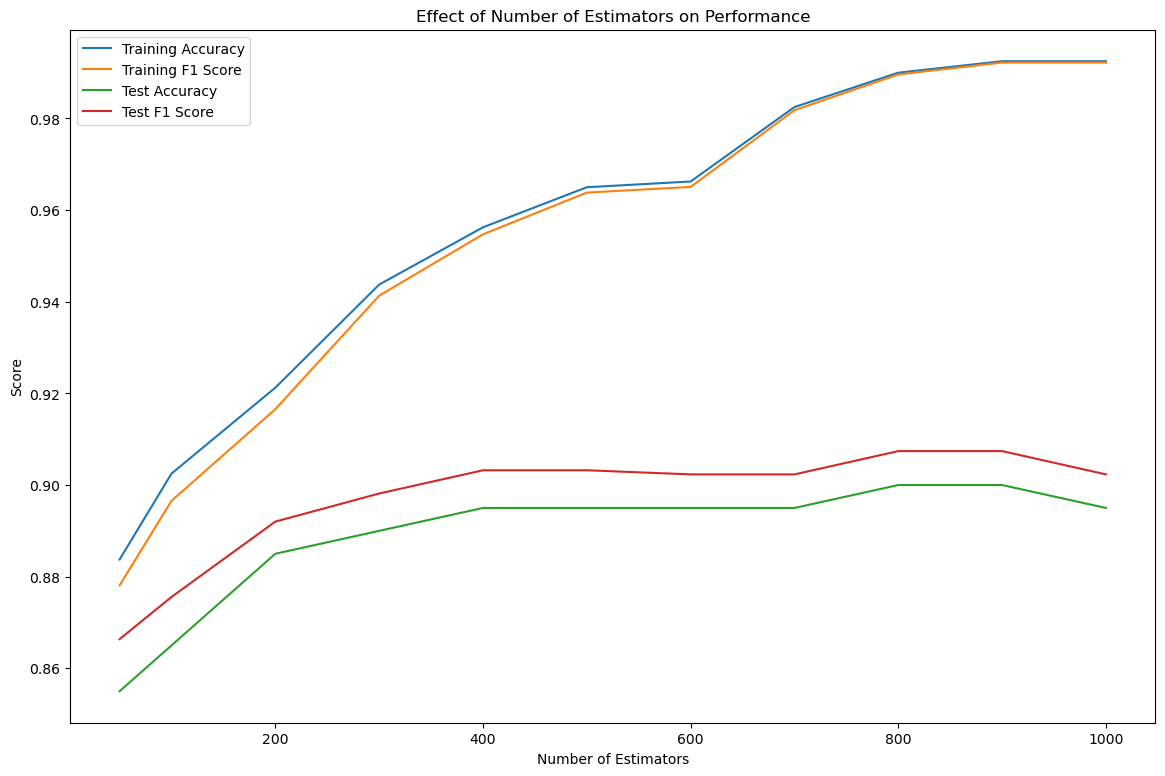

In [7]:
n_estimators_values = [50, 100, 200, 300, 400, 500,  600, 700, 800, 900, 1000]
learning_rate = 0.1
tree_depth = 3

# Lists to store the performance metrics
train_accuracy_scores = []
train_f1_scores = []
test_accuracy_scores = []
test_f1_scores = []

for n_estimators in n_estimators_values:
    # Evaluate GBRT on Dataset 1
    accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test = evaluate_model(GBRT, X1_train, y1_train.astype(int), X1_test, y1_test.astype(int), n_estimators=n_estimators, learning_rate=learning_rate, tree_depth=tree_depth)

    # Append the scores to the respective lists
    train_accuracy_scores.append(accuracy_train)
    train_f1_scores.append(f1_train)
    test_accuracy_scores.append(accuracy_test)
    test_f1_scores.append(f1_test)

# Plot the results
plt.figure(figsize=(14, 9))
plt.plot(n_estimators_values, train_accuracy_scores, label='Training Accuracy')
plt.plot(n_estimators_values, train_f1_scores, label='Training F1 Score')
plt.plot(n_estimators_values, test_accuracy_scores, label='Test Accuracy')
plt.plot(n_estimators_values, test_f1_scores, label='Test F1 Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Effect of Number of Estimators on Performance')
plt.legend()
plt.show()


Seems that n_estimators of around 800-100 is best for dataset1

##### Tree Depth
Now, let's check how tree depth effects it

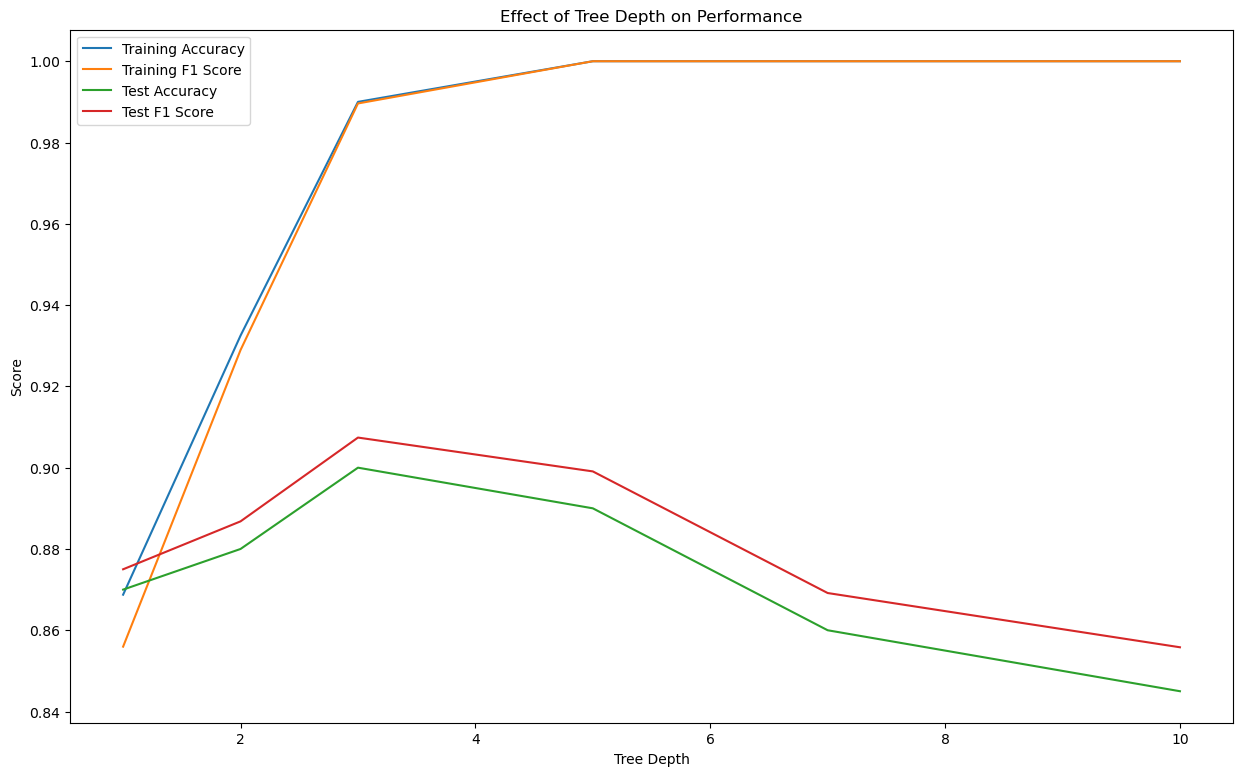

In [8]:
n_estimators = 800
learning_rate = 0.1
tree_depth_values = [1, 2, 3, 5, 7, 10]

# Lists to store the performance metrics
train_accuracy_scores = []
train_f1_scores = []
test_accuracy_scores = []
test_f1_scores = []

for tree_depth in tree_depth_values:
    # Evaluate GBRT on Dataset 1
    accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test = evaluate_model(GBRT, X1_train, y1_train.astype(int), X1_test, y1_test.astype(int), n_estimators=n_estimators, learning_rate=learning_rate, tree_depth=tree_depth)

    # Append the scores to the respective lists
    train_accuracy_scores.append(accuracy_train)
    train_f1_scores.append(f1_train)
    test_accuracy_scores.append(accuracy_test)
    test_f1_scores.append(f1_test)

# Plot the results
plt.figure(figsize=(15, 9))
plt.plot(tree_depth_values, train_accuracy_scores, label='Training Accuracy')
plt.plot(tree_depth_values, train_f1_scores, label='Training F1 Score')
plt.plot(tree_depth_values, test_accuracy_scores, label='Test Accuracy')
plt.plot(tree_depth_values, test_f1_scores, label='Test F1 Score')
plt.xlabel('Tree Depth')
plt.ylabel('Score')
plt.title('Effect of Tree Depth on Performance')
plt.legend()
plt.show()


As we thought, we overfit when the tree depth is too large. Optimal depth is 3. Let's remind ourselves that 5 features are relevant, while the other 5 are not as relevant

##### Learning Rate
now, let's check the LR

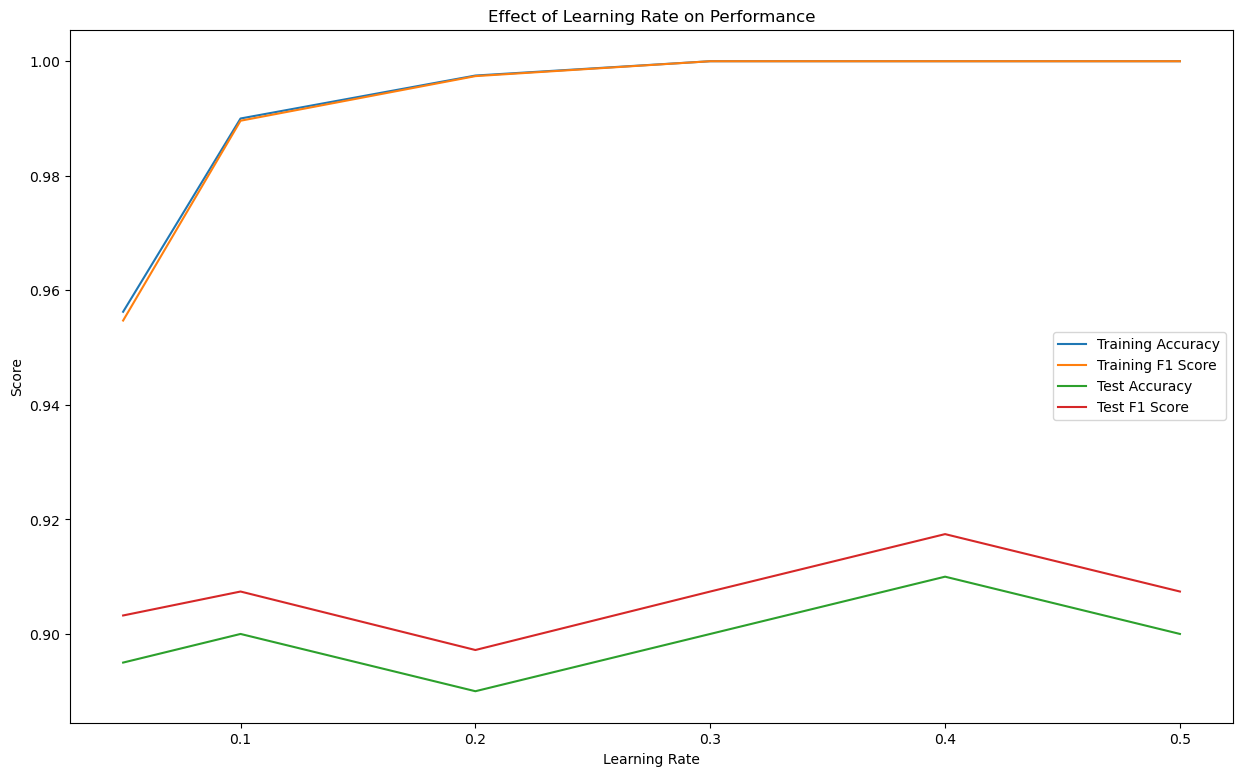

In [9]:
n_estimators = 800
learning_rate_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
tree_depth = 3

# Lists to store the performance metrics
train_accuracy_scores = []
train_f1_scores = []
test_accuracy_scores = []
test_f1_scores = []

for learning_rate in learning_rate_values:
    # Evaluate GBRT on Dataset 1
    accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test = evaluate_model(GBRT, X1_train, y1_train.astype(int), X1_test, y1_test.astype(int), n_estimators=n_estimators, learning_rate=learning_rate, tree_depth=tree_depth)

    # Append the scores to the respective lists
    train_accuracy_scores.append(accuracy_train)
    train_f1_scores.append(f1_train)
    test_accuracy_scores.append(accuracy_test)
    test_f1_scores.append(f1_test)

# Plot the results
plt.figure(figsize=(15, 9))
plt.plot(learning_rate_values, train_accuracy_scores, label='Training Accuracy')
plt.plot(learning_rate_values, train_f1_scores, label='Training F1 Score')
plt.plot(learning_rate_values, test_accuracy_scores, label='Test Accuracy')
plt.plot(learning_rate_values, test_f1_scores, label='Test F1 Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Effect of Learning Rate on Performance')
plt.legend()
plt.show()


Seems that optimal LR for dataset1 is 0.4.

#### DS2
##### N Estimators

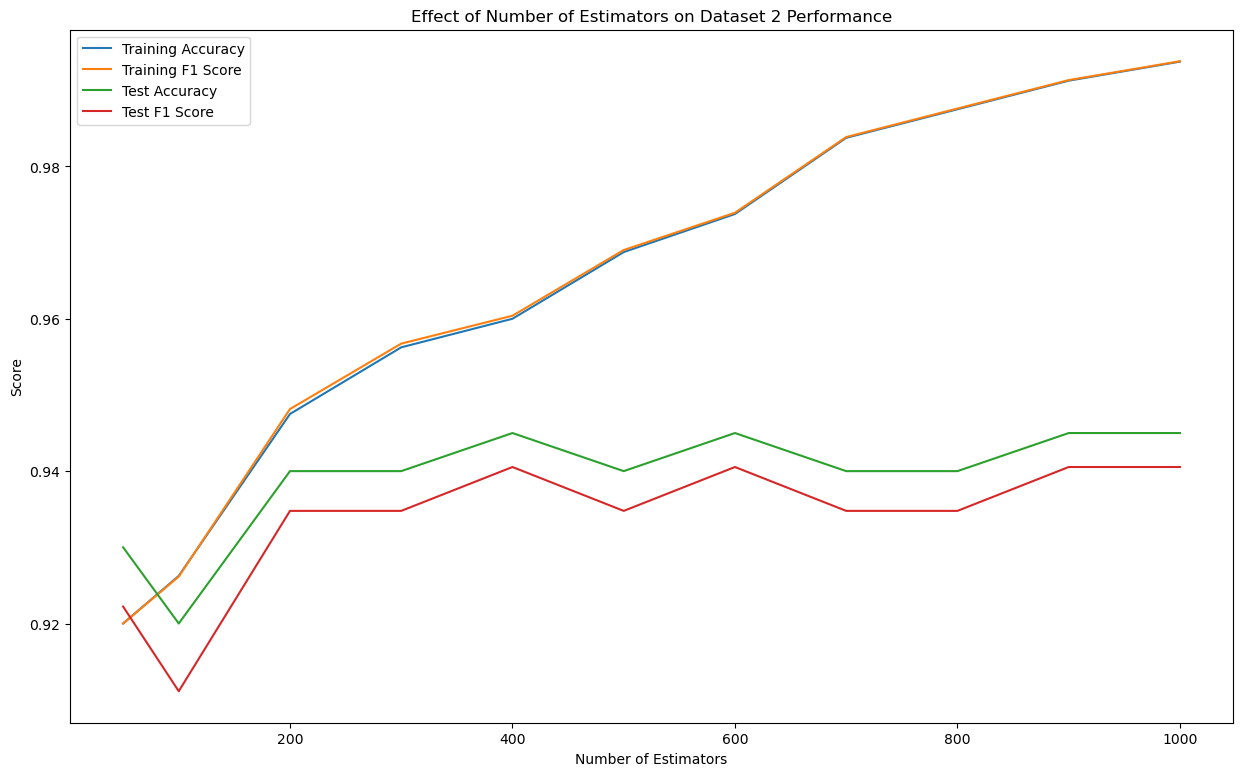

In [10]:
# Step 1: Vary the number of estimators (n_estimators)
n_estimators_values = [50, 100, 200, 300, 400, 500,  600, 700, 800, 900, 1000]
learning_rate = 0.1
tree_depth = 3

train_accuracy_scores = []
train_f1_scores = []
test_accuracy_scores = []
test_f1_scores = []

for n_estimators in n_estimators_values:
    accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test = evaluate_model(GBRT, X2_train, y2_train.astype(int), X2_test, y2_test.astype(int), n_estimators=n_estimators, learning_rate=learning_rate, tree_depth=tree_depth)

    train_accuracy_scores.append(accuracy_train)
    train_f1_scores.append(f1_train)
    test_accuracy_scores.append(accuracy_test)
    test_f1_scores.append(f1_test)

plt.figure(figsize=(15, 9))
plt.plot(n_estimators_values, train_accuracy_scores, label='Training Accuracy')
plt.plot(n_estimators_values, train_f1_scores, label='Training F1 Score')
plt.plot(n_estimators_values, test_accuracy_scores, label='Test Accuracy')
plt.plot(n_estimators_values, test_f1_scores, label='Test F1 Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Effect of Number of Estimators on Dataset 2 Performance')
plt.legend()
plt.show()


##### Tree Depth

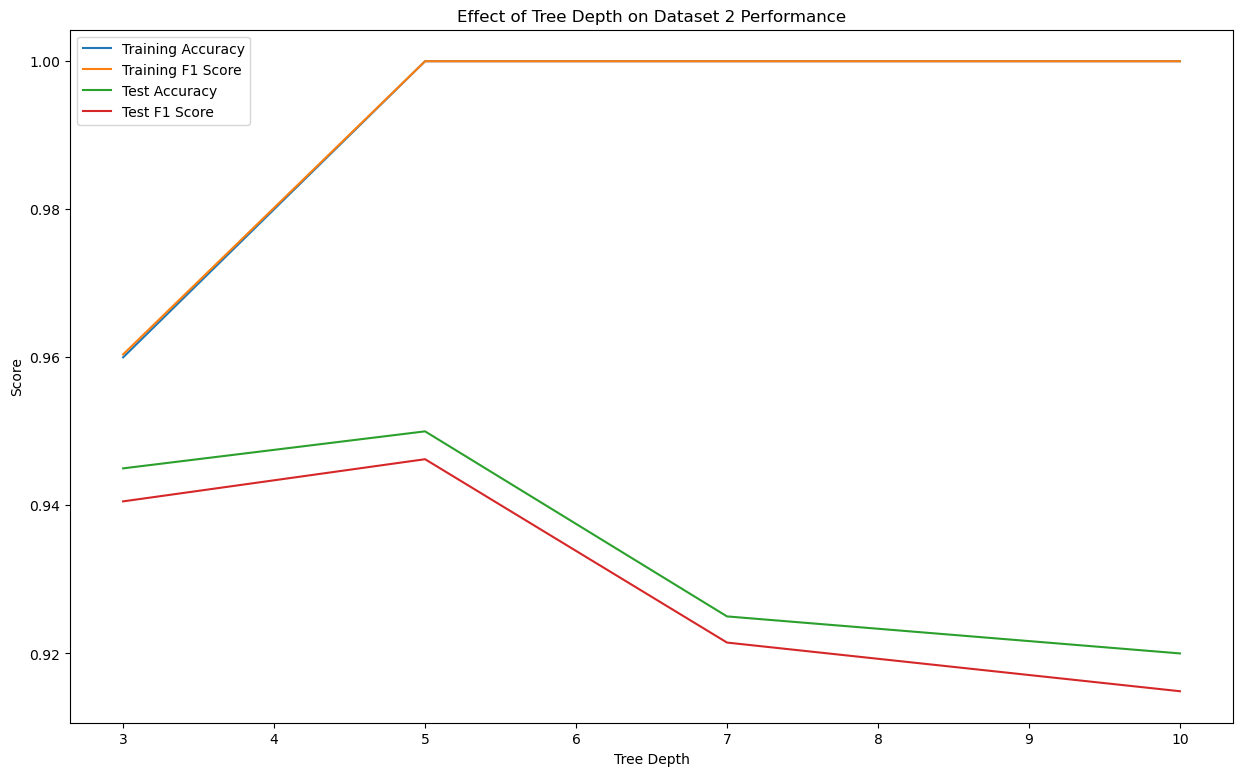

In [11]:
# Step 2: Vary the tree depth (tree_depth)
n_estimators = 400
tree_depth_values = [3, 5, 7, 10]

train_accuracy_scores = []
train_f1_scores = []
test_accuracy_scores = []
test_f1_scores = []

for tree_depth in tree_depth_values:
    accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test = evaluate_model(GBRT, X2_train, y2_train.astype(int), X2_test, y2_test.astype(int), n_estimators=n_estimators, learning_rate=learning_rate, tree_depth=tree_depth)

    train_accuracy_scores.append(accuracy_train)
    train_f1_scores.append(f1_train)
    test_accuracy_scores.append(accuracy_test)
    test_f1_scores.append(f1_test)

plt.figure(figsize=(15, 9))
plt.plot(tree_depth_values, train_accuracy_scores, label='Training Accuracy')
plt.plot(tree_depth_values, train_f1_scores, label='Training F1 Score')
plt.plot(tree_depth_values, test_accuracy_scores, label='Test Accuracy')
plt.plot(tree_depth_values, test_f1_scores, label='Test F1 Score')
plt.xlabel('Tree Depth')
plt.ylabel('Score')
plt.title('Effect of Tree Depth on Dataset 2 Performance')
plt.legend()
plt.show()



##### Learning Rate

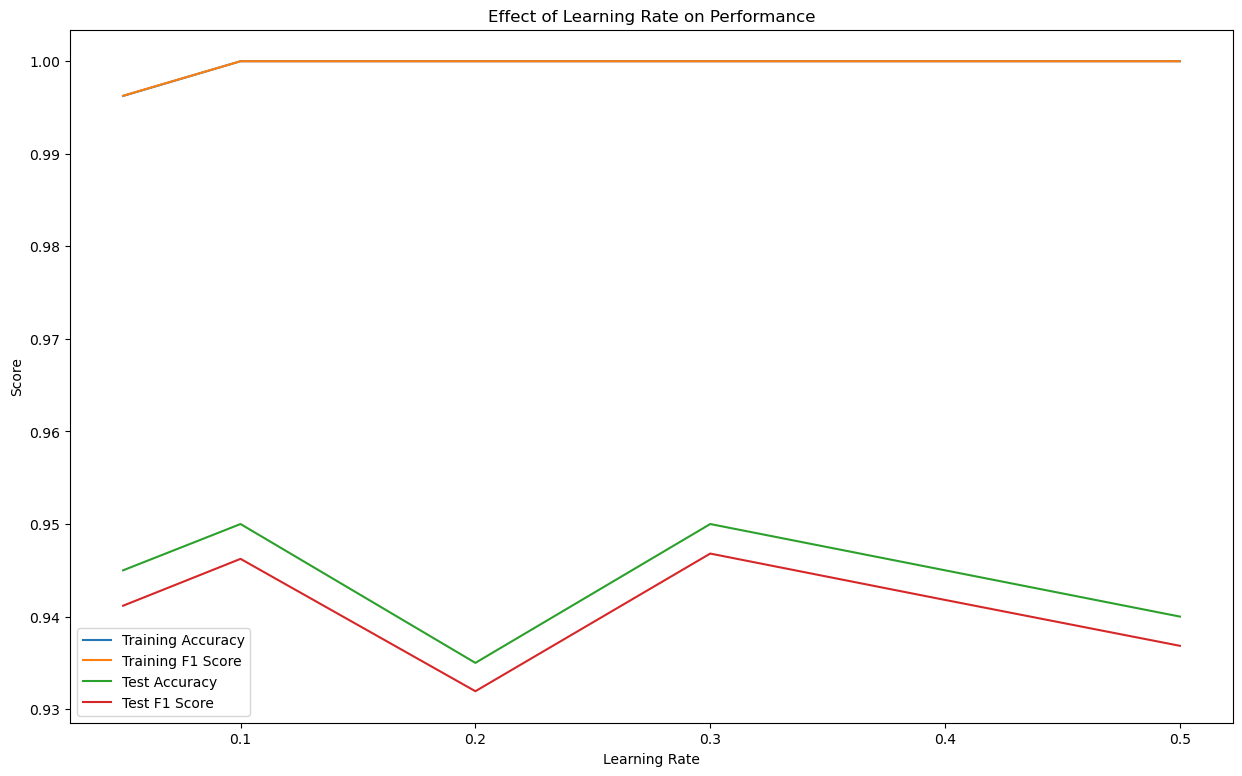

In [12]:
# Step 3: Vary the learning rate (learning_rate)
n_estimators = 400
tree_depth = 5
learning_rate_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

train_accuracy_scores = []
train_f1_scores = []
test_accuracy_scores = []
test_f1_scores = []

for learning_rate in learning_rate_values:
    accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test = evaluate_model(GBRT, X2_train, y2_train.astype(int), X2_test, y2_test.astype(int), n_estimators=n_estimators, learning_rate=learning_rate, tree_depth=tree_depth)

    train_accuracy_scores.append(accuracy_train)
    train_f1_scores.append(f1_train)
    test_accuracy_scores.append(accuracy_test)
    test_f1_scores.append(f1_test)

# Plot the results
plt.figure(figsize=(15, 9))
plt.plot(learning_rate_values, train_accuracy_scores, label='Training Accuracy')
plt.plot(learning_rate_values, train_f1_scores, label='Training F1 Score')
plt.plot(learning_rate_values, test_accuracy_scores, label='Test Accuracy')
plt.plot(learning_rate_values, test_f1_scores, label='Test F1 Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Effect of Learning Rate on Performance')
plt.legend()
plt.show()

Seems that optimal n_esitmators is enywhere between 400-1000
</br>
Seems that optimal tree depth is between 3 to 5.
</br>
Seems that optimal LR is 0.3.

### Results

Let's get the best model for dataset1

In [13]:
n_estimators = 800
max_depth = 3
learning_rate = 0.1

accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test = evaluate_model(GBRT, X1_train, y1_train.astype(int), X1_test, y1_test.astype(int), n_estimators=n_estimators, learning_rate=learning_rate, tree_depth=max_depth)

print("GBRT Performance on Dataset 1:")
print("Training Accuracy:", round(accuracy_train, 3))
print("Training Precision:", round(precision_train, 3))
print("Training Recall:", round(recall_train, 3))
print("Training F1 Score:", round(f1_train, 3))
print()
print("Test Accuracy:", round(accuracy_test, 3))
print("Test Precision:", round(precision_test, 3))
print("Test Recall:", round(recall_test, 3))
print("Test F1 Score:", round(f1_test, 3))


GBCT Performance on Dataset 1:
Training Accuracy: 0.99
Training Precision: 0.99
Training Recall: 0.99
Training F1 Score: 0.99

Test Accuracy: 0.9
Test Precision: 0.933
Test Recall: 0.883
Test F1 Score: 0.907


We improved the f1 score from 0.87 to 0.91 on the test set!

Let's get the best model for dataset2

In [37]:
n_estimators = 500
max_depth = 5
learning_rate = 0.3

accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test = evaluate_model(GBRT, X2_train, y2_train.astype(int), X2_test, y2_test.astype(int), n_estimators=n_estimators, learning_rate=learning_rate, tree_depth=max_depth)

print("GBRT Performance on Dataset 2:")
print("Training Accuracy:", round(accuracy_train, 3))
print("Training Precision:", round(precision_train, 3))
print("Training Recall:", round(recall_train, 3))
print("Training F1 Score:", round(f1_train, 3))
print()
print("Test Accuracy:", round(accuracy_test, 3))
print("Test Precision:", round(precision_test, 3))
print("Test Recall:", round(recall_test, 3))
print("Test F1 Score:", round(f1_test, 3))


NameError: name 'GBRT' is not defined

1. We improved the f1 score from 0.91 to 0.95 on the test set!
2. Performance on dataset 2 was generally better than on dataset1.

## Part 2: AdaBoost
7) Implement AdaBoost
a) Weights (𝑤!)
b) Decision stump
c) Weighted classification error (𝜖)
d) Step size (𝛼)
e) Boosting step
f) Updating weights


In [15]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
class AdaBoost:
    def __init__(self, n_estimators):
        self.num_estimators = n_estimators
        self.estimators = []
        self.estimator_weights = []

        
    def initialize_weights(self, num_samples):
        return np.ones(num_samples) / num_samples

    
    def train_decision_stump(self, X, y, weights):
        stump = DecisionTreeClassifier(max_depth=1) # Use stumps
        stump.fit(X, y, sample_weight=weights)
        return stump


    def calculate_weighted_error(self, y_true, y_pred, weights):
        incorrect = np.not_equal(y_true, y_pred)
        weighted_error = np.sum(weights[incorrect])
        return weighted_error

    
    def calculate_step_size(self, weighted_error):
        return 0.5 * np.log((1 - weighted_error) / weighted_error)

    
    def update_weights(self, weights, step_size, y_true, y_pred):
        update_factor = np.exp(-step_size * y_true * y_pred)
        updated_weights = weights * update_factor
        updated_weights /= np.sum(updated_weights)
        return updated_weights

    
    def fit(self, X, y):
        num_samples = len(X)
        weights = self.initialize_weights(num_samples)

        for _ in range(self.num_estimators):
            stump = self.train_decision_stump(X, y, weights)
            y_pred = stump.predict(X)
            weighted_error = self.calculate_weighted_error(y, y_pred, weights)
            step_size = self.calculate_step_size(weighted_error)

            weights = self.update_weights(weights, step_size, y, y_pred)

            self.estimators.append(stump)
            self.estimator_weights.append(step_size)

            
    def predict_proba(self, X):
        num_samples = len(X)
        scores = np.zeros(num_samples)

        for i in range(self.num_estimators):
            y_pred = self.estimators[i].predict(X)
            scores += self.estimator_weights[i] * y_pred

        return np.sign(scores)


### Model Evaluation

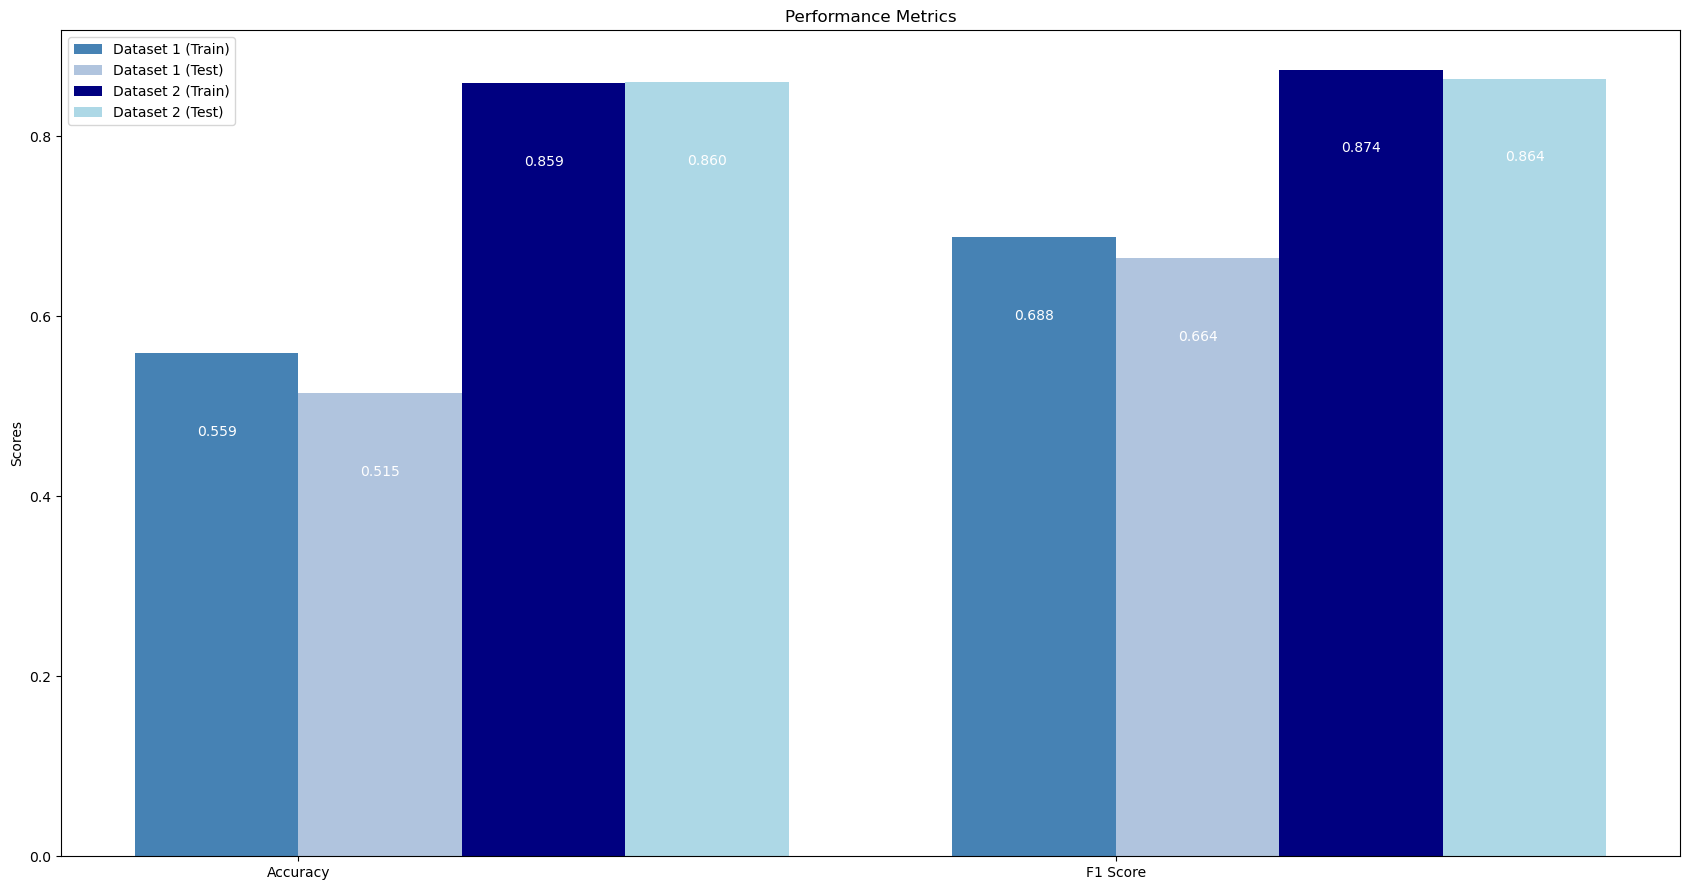

In [33]:
# Evaluate AdaBoost on Dataset 1
accuracy_train1, precision_train1, recall_train1, f1_train1, accuracy_test1, precision_test1, recall_test1, f1_test1 = evaluate_model(AdaBoost, X1_train, y1_train.astype(int), X1_test, y1_test.astype(int), adaboost_flag=True)

# Evaluate AdaBoost on Dataset 2
accuracy_train2, precision_train2, recall_train2, f1_train2, accuracy_test2, precision_test2, recall_test2, f1_test2 = evaluate_model(AdaBoost, X2_train, y2_train.astype(int), X2_test, y2_test.astype(int), adaboost_flag=True)

# Create a bar plot
labels = ['Accuracy', 'F1 Score']
dataset1_train_scores = [accuracy_train1, f1_train1]
dataset1_test_scores = [accuracy_test1, f1_test1]
dataset2_train_scores = [accuracy_train2, f1_train2]
dataset2_test_scores = [accuracy_test2, f1_test2]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(17, 9))
rects1 = ax.bar(x - width/2, dataset1_train_scores, width, label='Dataset 1 (Train)', color='steelblue')
rects2 = ax.bar(x + width/2, dataset1_test_scores, width, label='Dataset 1 (Test)', color='lightsteelblue')
rects3 = ax.bar(x + 3*width/2, dataset2_train_scores, width, label='Dataset 2 (Train)', color='navy')
rects4 = ax.bar(x + 5*width/2, dataset2_test_scores, width, label='Dataset 2 (Test)', color='lightblue')

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='best')

# Add text labels on top of the bars
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.tight_layout()
plt.show()




Here we see the same trend as before, where the model works better on dataset2. The possible explanation to it is the same we have offered beforehand.

### Experiments
The only experiment that is available here is the N estimators experiment, as AdaBoost has less hyper-parameteres: 

#### N Estimators

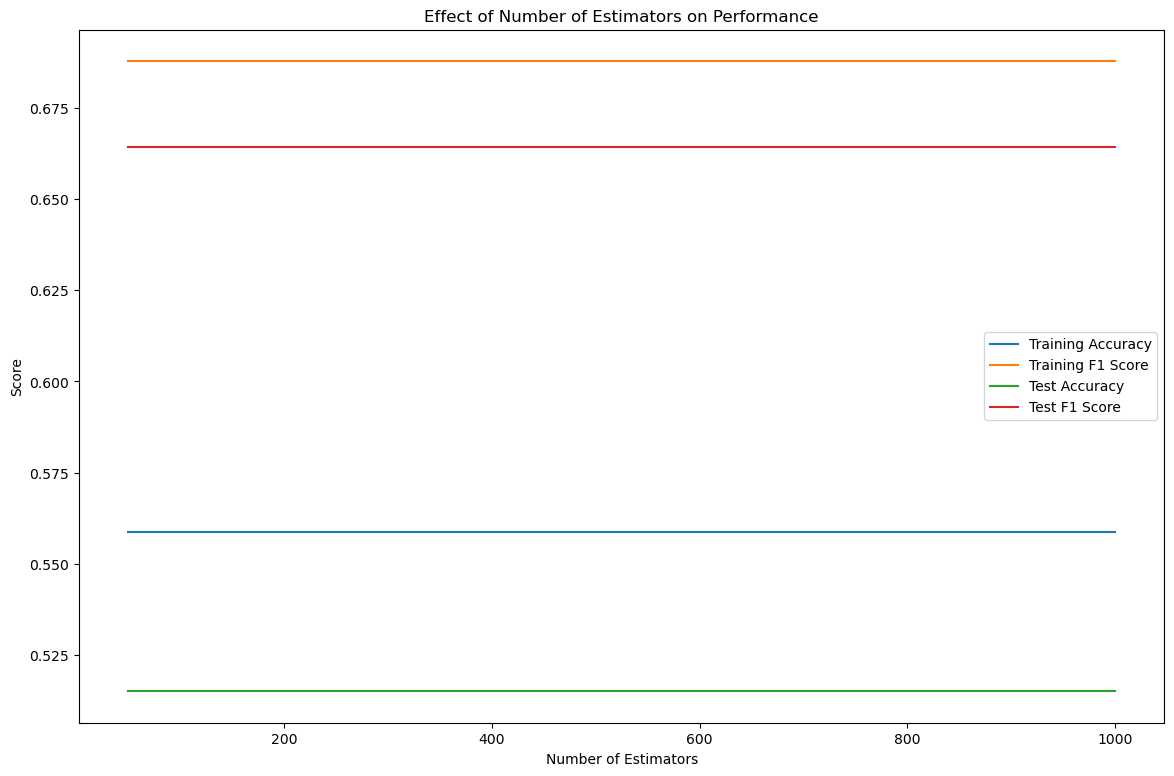

In [34]:
n_estimators_values = [50, 100, 200, 300, 400, 500,  600, 700, 800, 900, 1000]

# Lists to store the performance metrics
train_accuracy_scores = []
train_f1_scores = []
test_accuracy_scores = []
test_f1_scores = []

for n_estimators in n_estimators_values:
    accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test = evaluate_model(AdaBoost, X1_train, y1_train.astype(int), X1_test, y1_test.astype(int), n_estimators=n_estimators, adaboost_flag=True)

    train_accuracy_scores.append(accuracy_train)
    train_f1_scores.append(f1_train)
    test_accuracy_scores.append(accuracy_test)
    test_f1_scores.append(f1_test)

# Plot the results
plt.figure(figsize=(14, 9))
plt.plot(n_estimators_values, train_accuracy_scores, label='Training Accuracy')
plt.plot(n_estimators_values, train_f1_scores, label='Training F1 Score')
plt.plot(n_estimators_values, test_accuracy_scores, label='Test Accuracy')
plt.plot(n_estimators_values, test_f1_scores, label='Test F1 Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Effect of Number of Estimators on Performance')
plt.legend()
plt.show()



It seems like neither results improve if we change the number of weak learners for the first dataset. It might be caused due to the fact the dataset isn't overly complex. We'll try again with small numbers of weak learners:

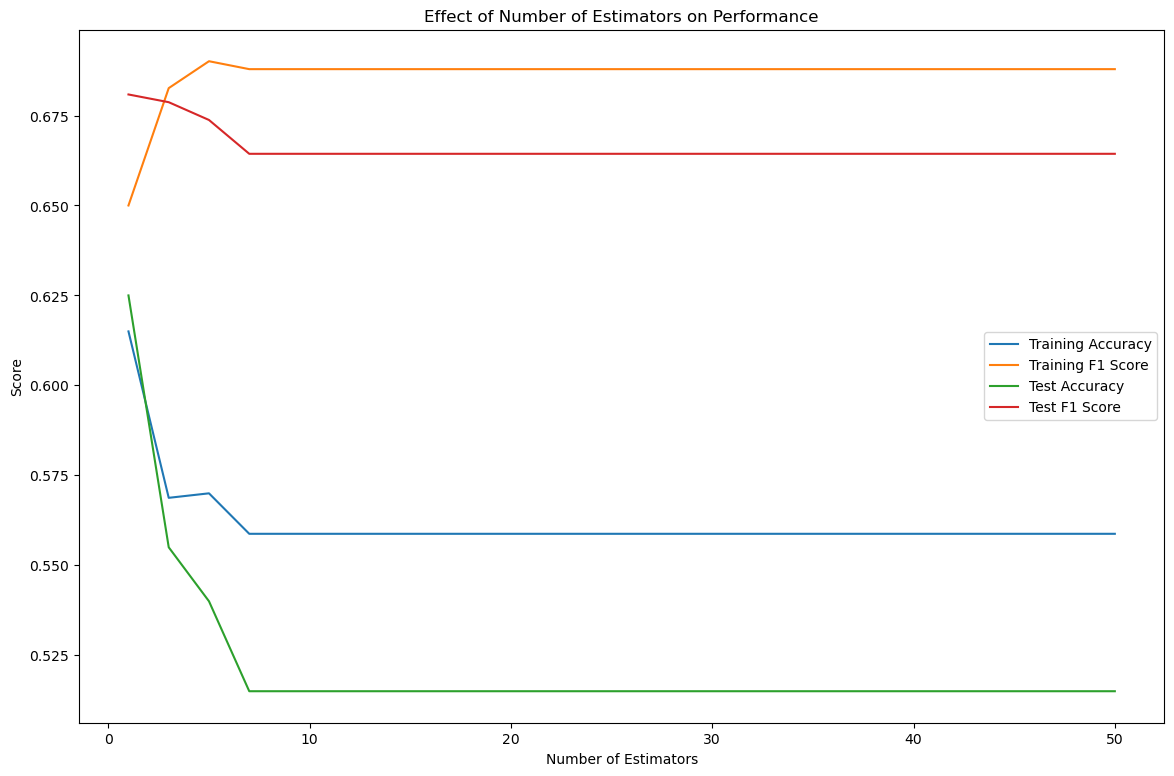

In [35]:
n_estimators_values = [1, 3, 5, 7, 10, 50]

# Lists to store the performance metrics
train_accuracy_scores = []
train_f1_scores = []
test_accuracy_scores = []
test_f1_scores = []

for n_estimators in n_estimators_values:
    accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test = evaluate_model(AdaBoost, X1_train, y1_train.astype(int), X1_test, y1_test.astype(int), n_estimators=n_estimators, adaboost_flag=True)

    train_accuracy_scores.append(accuracy_train)
    train_f1_scores.append(f1_train)
    test_accuracy_scores.append(accuracy_test)
    test_f1_scores.append(f1_test)

# Plot the results
plt.figure(figsize=(14, 9))
plt.plot(n_estimators_values, train_accuracy_scores, label='Training Accuracy')
plt.plot(n_estimators_values, train_f1_scores, label='Training F1 Score')
plt.plot(n_estimators_values, test_accuracy_scores, label='Test Accuracy')
plt.plot(n_estimators_values, test_f1_scores, label='Test F1 Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Effect of Number of Estimators on Performance')
plt.legend()
plt.show()



In [36]:
from sklearn.ensemble import AdaBoostClassifier 

In [ ]:
AdaBoostClassifier()

The maximum over the test set is achived with just 3 weak learners, and afterwards it gets overfitted. <br>
Moving on to DS2

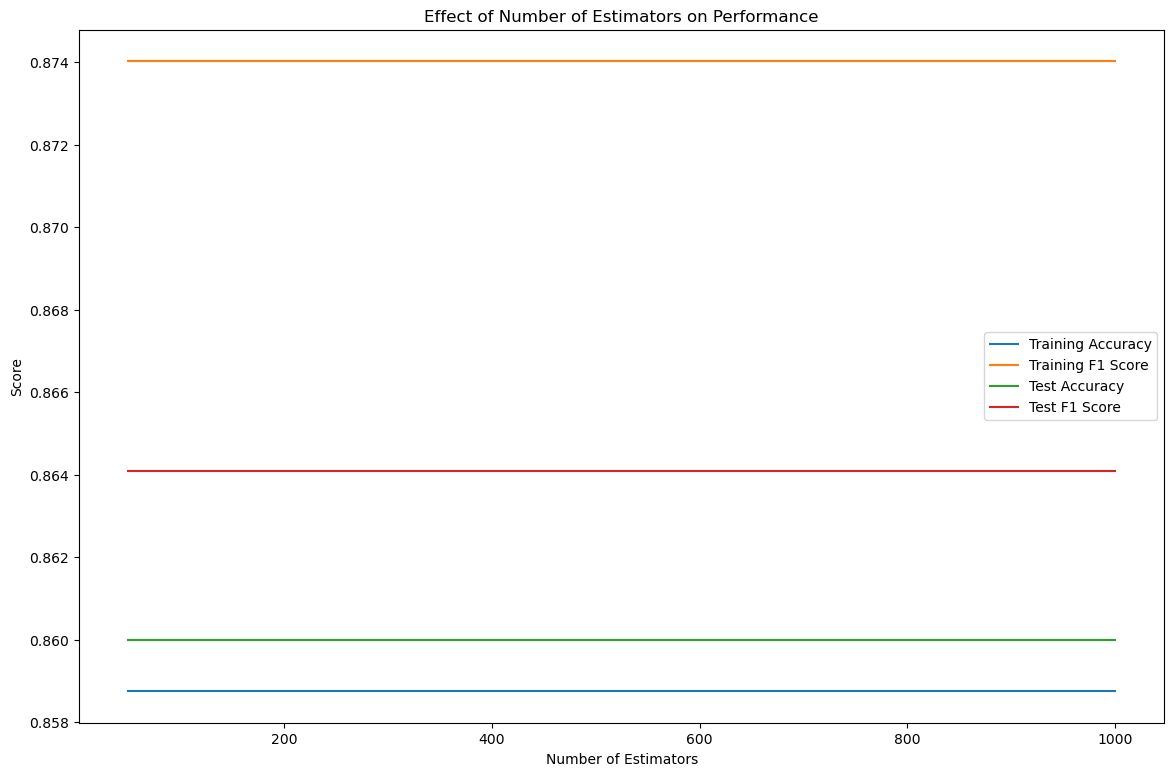

In [20]:
n_estimators_values = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Lists to store the performance metrics
train_accuracy_scores = []
train_f1_scores = []
test_accuracy_scores = []
test_f1_scores = []

for n_estimators in n_estimators_values:
    accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test = evaluate_model(AdaBoost, X2_train, y2_train.astype(int), X2_test, y2_test.astype(int), n_estimators=n_estimators, adaboost_flag=True)

    train_accuracy_scores.append(accuracy_train)
    train_f1_scores.append(f1_train)
    test_accuracy_scores.append(accuracy_test)
    test_f1_scores.append(f1_test)

# Plot the results
plt.figure(figsize=(14, 9))
plt.plot(n_estimators_values, train_accuracy_scores, label='Training Accuracy')
plt.plot(n_estimators_values, train_f1_scores, label='Training F1 Score')
plt.plot(n_estimators_values, test_accuracy_scores, label='Test Accuracy')
plt.plot(n_estimators_values, test_f1_scores, label='Test F1 Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Effect of Number of Estimators on Performance')
plt.legend()
plt.show()



Same as before, so we'll try a small number of learners:

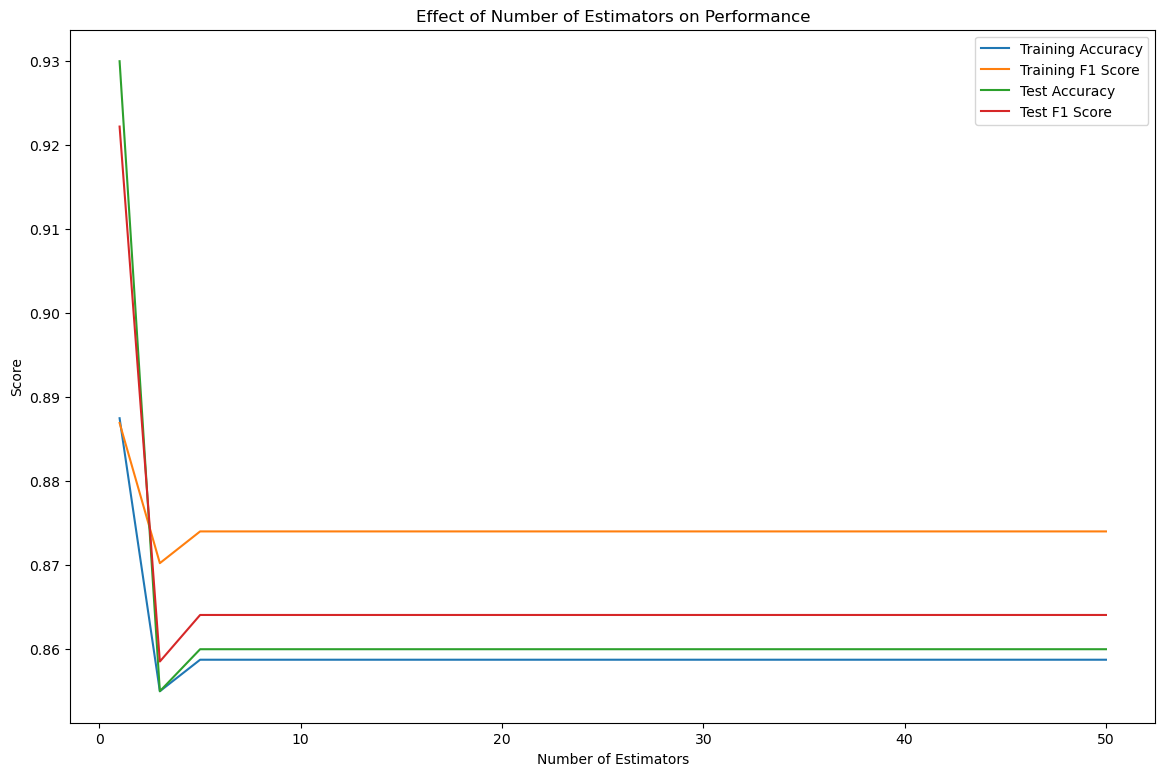

In [21]:
n_estimators_values = [1, 3, 5, 7, 10, 50]

# Lists to store the performance metrics
train_accuracy_scores = []
train_f1_scores = []
test_accuracy_scores = []
test_f1_scores = []

for n_estimators in n_estimators_values:
    accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test = evaluate_model(AdaBoost, X2_train, y2_train.astype(int), X2_test, y2_test.astype(int), n_estimators=n_estimators, adaboost_flag=True)

    train_accuracy_scores.append(accuracy_train)
    train_f1_scores.append(f1_train)
    test_accuracy_scores.append(accuracy_test)
    test_f1_scores.append(f1_test)

# Plot the results
plt.figure(figsize=(14, 9))
plt.plot(n_estimators_values, train_accuracy_scores, label='Training Accuracy')
plt.plot(n_estimators_values, train_f1_scores, label='Training F1 Score')
plt.plot(n_estimators_values, test_accuracy_scores, label='Test Accuracy')
plt.plot(n_estimators_values, test_f1_scores, label='Test F1 Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Effect of Number of Estimators on Performance')
plt.legend()
plt.show()



It seems that the maximum is achieved here by just 1 weak learner!

### Results

In [22]:
n_estimators = 3

accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test = evaluate_model(AdaBoost, X1_train, y1_train.astype(int), X1_test, y1_test.astype(int), n_estimators=n_estimators, adaboost_flag=True)

print("AdaBoost Performance on Dataset 1:")
print("Training Accuracy:", round(accuracy_train, 3))
print("Training Precision:", round(precision_train, 3))
print("Training Recall:", round(recall_train, 3))
print("Training F1 Score:", round(f1_train, 3))
print()
print("Test Accuracy:", round(accuracy_test, 3))
print("Test Precision:", round(precision_test, 3))
print("Test Recall:", round(recall_test, 3))
print("Test F1 Score:", round(f1_test, 3))


AdaBoost Performance on Dataset 1:
Training Accuracy: 0.749
Training Precision: 0.731
Training Recall: 0.756
Training F1 Score: 0.743

Test Accuracy: 0.77
Test Precision: 0.828
Test Recall: 0.739
Test F1 Score: 0.781


In [23]:
n_estimators = 1

accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test = evaluate_model(AdaBoost, X2_train, y2_train.astype(int), X2_test, y2_test.astype(int), n_estimators=n_estimators, adaboost_flag=True)

print("AdaBoost Performance on Dataset 2:")
print("Training Accuracy:", round(accuracy_train, 3))
print("Training Precision:", round(precision_train, 3))
print("Training Recall:", round(recall_train, 3))
print("Training F1 Score:", round(f1_train, 3))
print()
print("Test Accuracy:", round(accuracy_test, 3))
print("Test Precision:", round(precision_test, 3))
print("Test Recall:", round(recall_test, 3))
print("Test F1 Score:", round(f1_test, 3))


AdaBoost Performance on Dataset 2:
Training Accuracy: 0.888
Training Precision: 0.901
Training Recall: 0.874
Training F1 Score: 0.887

Test Accuracy: 0.93
Test Precision: 0.954
Test Recall: 0.892
Test F1 Score: 0.922
